Who is Paying for the Primaries?
-------------------------------------
(A work in progress)

The Federal Elections Committee requires all candidates to submit quarterly reports detailing individual contributions as well as a list of expenses. These are available online at (http://www.fec.gov/press/resources/2016presidential_form2nm.shtml). I've pulled all filings for the Republican candidates plus Clinton up through July (some candidates weren't yet officially registered, so they didn't have to file). You can find all of the reports in a spreadsheet at [insert].

The data arrives in 1 CSV file per candidate. After inspecting the data, it appears that the first two rows are meaningless.

In [1]:
import pandas as pd
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
df_rosetta = pd.read_excel("C:/Users/riguy/SkyDrive/Documents/FEC_Defns.xlsx", sheetname="all versions", header=None)
df_rosetta = df_rosetta[df_rosetta[0] == "v8.1"]

In [3]:
all_candidates = pd.read_excel("C:/Users/riguy/SkyDrive/Documents/RNC_contributions.xlsx", sheetname=None, skiprows=2, header=None)

In [4]:
for candidate, data in all_candidates.iteritems():
    data["candidate"] = candidate

In [5]:
# Get the form types
all_candidates["Jindal"].groupby(0).agg({1: len})

,1
0,
SA17A,258
SA17C,1
SB23,34


What I know about the form types:
* SA17A is individual contributions
* SA17C appears to be contributions from other organizations.
* SB28A is refunds to individuals
* There are a few more that I'll list as I need them.

Some of this was derived from this blog: http://www.mornin.org/blog/wrangling-fecs-2012-presidential-campaign-finance-/

The meaning of the columns in each row is determined by the form type as defined in df_rosetta above, which I got from the fec at http://www.fec.gov/finance/disclosure/ftpefile.shtml. I am pretty sure we are using v8.1 of the standard.


I actually want to pivot the data from organized by candidate to organized by type of line. This next section does exactly that.

Data Cleaning
--------------

In [6]:
def build_subset(df_individual, key="SA"):
    columns = df_rosetta[df_rosetta[1] == key][range(2, len(df_rosetta[1]))].as_matrix()
    columns = [a.split('-')[1].split('{')[0].replace(' ', '') for a in columns[0] if not pd.isnull(a)]
    df_individual = df_individual[range(len(columns)) + ["candidate"]]
    columns = columns + ["candidate"]
    df_individual.columns = columns
    return df_individual

In [7]:
individual_contributions = list()
for k, v in all_candidates.iteritems():
    v_i = v[v[0] == "SA17A"]
    v_i = build_subset(v_i, "SA")
    individual_contributions.append(v_i)

In [8]:
df_individual = pd.concat(individual_contributions)
df_individual_rnc = df_individual[df_individual.candidate != "DNC_Clinton"]

Now that we have only RNC candidates, we can start to examine the contributions. We'll start by looking at states that are paying for the RNC primary.

Contributions by State
----------------------

In [9]:
contributions_by_state = df_individual_rnc.groupby("CONTRIBUTORSTATE").agg({"CONTRIBUTIONAMOUNT": sum})\
    .sort("CONTRIBUTIONAMOUNT", ascending=False)
contributions_by_state["RelativeContribution"] = contributions_by_state.CONTRIBUTIONAMOUNT / contributions_by_state.CONTRIBUTIONAMOUNT.sum()
contributions_by_state_dict = contributions_by_state.RelativeContribution.to_dict()

In [10]:
contributions_by_state.head()

,CONTRIBUTIONAMOUNT,RelativeContribution
CONTRIBUTORSTATE,,
TX,9065765.40,0.255642
FL,5314168.12,0.149852
CA,4075912.85,0.114935
NY,2426093.39,0.068412
SC,1146856.96,0.032340


Now we've got total contributions by state. The next two cells are setup. First, I need to grab a map of states to their abbreviations. Then I'll set up our plot function, which I pretty much copied directly from stackoverflow.

In [11]:
import requests
from json import loads
f = requests.get("https://gist.githubusercontent.com/mshafrir/2646763/raw/8b0dbb93521f5d6889502305335104218454c2bf/states_hash.json")
states = loads(f.content)
states['DC'] = 'District of Columbia'  # was Of not of. data is hard :)
rev_states = dict([(v, k) for k, v in states.iteritems()])

C:\Anaconda\lib\site-packages\requests\packages\urllib3\util\ssl_.py:90: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#insecureplatformwarning.
  InsecurePlatformWarning


In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon

def build_basic_map(contributions_dict, multiplier = 3):
    # create the map
    map = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
            projection='lcc',lat_1=33,lat_2=45,lon_0=-95)

    # load the shapefile, use the name 'states'
    map.readshapefile('./data/st99_d00', name='states', drawbounds=True)

    # collect the state names from the shapefile attributes so we can
    # look up the shape obect for a state by it's name
    state_names = []
    for shape_dict in map.states_info:
        state_names.append(shape_dict['NAME'])

    ax = plt.gca() # get current axes instance

    # get Texas and draw the filled polygon
    for key in states:
        try:
            seg = map.states[state_names.index(states[key])]
            poly = Polygon(seg, facecolor=plt.cm.hot_r(contributions_dict[key] * multiplier) ,edgecolor=None)
            ax.add_patch(poly)
        except ValueError:
            # print key
            pass # I printed these once. They are micronesia, ect.
    return plt


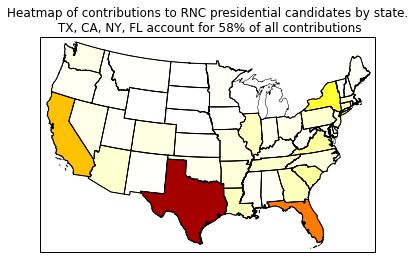

In [13]:
plt = build_basic_map(contributions_by_state_dict)
plt.title("Heatmap of contributions to RNC presidential candidates by state.\n TX, CA, NY, FL account for 58% of all contributions")
plt.show()

It should not be too surprising that TX, CA, NY, and FL are the top four: they are also the top four states by population, and Texas and Florida in particular have 2 candidates *each* in the RNC race. It may be interesting to normalize contributions by population.

In [14]:
# %load "data/populations_2014_wikipedia.py"
# I got this from https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_population
populations_2014_wikipedia = {
	"California": 38802500,
	"Texas": 26956958,
	"Florida": 19893297,
	"New York": 19746227,
	"Illinois": 12880580,
	"Pennsylvania": 12787209,
	"Ohio": 11594163,
	"Georgia": 10097343,
	"North Carolina": 9943964,
	"Michigan": 9909877,
	"New Jersey": 8938175,
	"Virginia": 8326289,
	"Washington": 7061530,
	"Massachusetts": 6745408,
	"Arizona": 6731484,
	"Indiana": 6596855,
	"Tennessee": 6549352,
	"Missouri": 6063589,
	"Maryland": 5976407,
	"Wisconsin": 5757564,
	"Minnesota": 5457173,
	"Colorado": 5355866,
	"Alabama": 4849377,
	"South Carolina": 4832482,
	"Louisiana": 4649676,
	"Kentucky": 4413457,
	"Oregon": 3970239,
	"Oklahoma": 3878051,
	"Puerto Rico": 3548397,
	"Connecticut": 3596677,
	"Iowa": 3107126,
	"Mississippi": 2994079,
	"Arkansas": 2966369,
	"Utah": 2942902,
	"Kansas": 2904021,
	"Nevada": 2839098,
	"New Mexico": 2085572,
	"Nebraska": 1881503,
	"West Virginia": 1850326,
	"Idaho": 1634464,
	"Hawaii": 1419561,
	"Maine": 1330089,
	"New Hampshire": 1326813,
	"Rhode Island": 1055173,
	"Montana": 1023579,
	"Delaware": 935614,
	"South Dakota": 853175,
	"North Dakota": 739482,
	"Alaska": 736732,
	"District of Columbia": 658893,
	"Vermont": 626562,
	"Wyoming": 584153
}

In [15]:
state_populations = pd.DataFrame([{'State': k, 'Pop': v} for k, v in populations_2014_wikipedia.iteritems()])
state_populations["RelativePop"] = state_populations.Pop / state_populations.Pop.sum()
state_populations["StateAbbrev"] = state_populations.State.apply(lambda x: rev_states.get(x, ""))
state_populations.head()

,Pop,State,RelativePop,StateAbbrev
0,2994079,Mississippi,0.009287,MS
1,3878051,Oklahoma,0.012028,OK
2,935614,Delaware,0.002902,DE
3,5457173,Minnesota,0.016926,MN
4,12880580,Illinois,0.039951,IL


In [16]:
contributions_by_state_with_pop = contributions_by_state.merge(state_populations, right_index=False, right_on="StateAbbrev", left_index=True, how="inner")
# NOTE: I checked this with an outer join first. Didn't see anything wonky.

In [17]:
contributions_by_state_with_pop["NormalizedContribution"] = contributions_by_state_with_pop.RelativeContribution / contributions_by_state_with_pop.RelativePop

In [18]:
contributions_by_state_with_pop.sort('NormalizedContribution', ascending=False).head(7)

,CONTRIBUTIONAMOUNT,RelativeContribution,Pop,State,RelativePop,StateAbbrev,NormalizedContribution
46,495043.60,0.013960,658893,District of Columbia,0.002044,DC,6.830600
9,9065765.40,0.255642,26956958,Texas,0.083612,TX,3.057482
41,5314168.12,0.149852,19893297,Florida,0.061703,FL,2.428616
39,1146856.96,0.032340,4832482,South Carolina,0.014989,SC,2.157592
12,754712.22,0.021282,3596677,Connecticut,0.011156,CT,1.907701
5,497570.72,0.014031,2966369,Arkansas,0.009201,AR,1.524965
8,768502.53,0.021671,4649676,Louisiana,0.014422,LA,1.502633


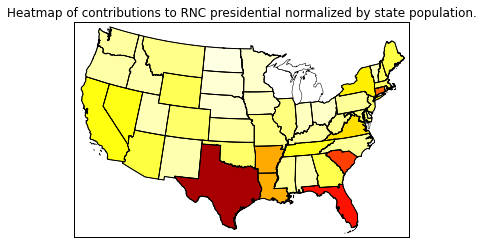

In [19]:
contributions_by_state_with_pop_dict = contributions_by_state_with_pop.set_index('StateAbbrev').NormalizedContribution.to_dict()
plt = build_basic_map(contributions_by_state_with_pop_dict, .25)
plt.title("Heatmap of contributions to RNC presidential normalized by state population.")
plt.show()

Normalizing by population, we see a few more interesting facts emerge.

First of all, Texas is still king. It's large, has a robust economy, two candidates, and it tends to swing right. Florida is also pretty active, which again makes sense given its candidates.

Arkansas and Lousiana both have a man in the race. As we'll see later, those states' contributions swing heavily towards "their man". This early in the cycle, it makes sense that governors or former governors would be hitting up their home turf.

South Carolina also has a candidate, which may explain their very high contribution per person relative to other states. It's also an early state, which is something we should pursue further. Overall, small state plus candidate plus early primary == not exciting.

The real story here is how much Connecticut lights up. Finance perhaps? Should explore more fully.

The real winner(?) here is D.C. with a contribution/person that is twice that the next closest state. 

Deep Dive: Who is winning at Home?
---------------------------------------

Below, we look at individual states that have candidates in the race. It's pretty clear that Cruz is killing in Texas. Bush is winning in Florida, but Rubio is punching about his national weight there. Smaller states with candidates like Arkansas or Louisiana are dominated by their hometown person.

In [20]:
df_individual_tx = df_individual_rnc[df_individual_rnc.CONTRIBUTORSTATE == "TX"]
df_individual_tx = df_individual_tx.groupby('candidate').agg({'CONTRIBUTIONAMOUNT': sum, 'CONTRIBUTIONDATE': [min, max]})
df_individual_tx.columns = ['CONTRIBUTIONAMOUNT', 'Min_ContributionDate', 'Max_ContributionDate']
df_individual_tx['RelativeContribution'] = df_individual_tx.CONTRIBUTIONAMOUNT / df_individual_tx.CONTRIBUTIONAMOUNT.sum()
df_individual_tx

,CONTRIBUTIONAMOUNT,Min_ContributionDate,Max_ContributionDate,RelativeContribution
candidate,,,,
Bush,1184645.00,20150615,20150630,0.130672
Cruz,5766373.69,20150322,20150630,0.636060
Fiorni,65822.99,20150504,20150630,0.007261
Graham,62425.00,20150219,20150630,0.006886
Huckabee,185557.87,20150406,20150630,0.020468
Jindal,21750.00,20150521,20150630,0.002399
Paul,313297.15,20150407,20150630,0.034558
Perry,630544.60,20150604,20150630,0.069552
Rubio,664919.10,20150401,20150630,0.073344


In [21]:
df_individual_fl = df_individual_rnc[df_individual_rnc.CONTRIBUTORSTATE == "FL"]
df_individual_fl = df_individual_fl.groupby('candidate').agg({'CONTRIBUTIONAMOUNT': sum, 'CONTRIBUTIONDATE': [min, max]})
df_individual_fl.columns = ['CONTRIBUTIONAMOUNT', 'Min_ContributionDate', 'Max_ContributionDate']
df_individual_fl['RelativeContribution'] = df_individual_fl.CONTRIBUTIONAMOUNT / df_individual_fl.CONTRIBUTIONAMOUNT.sum()
df_individual_fl

,CONTRIBUTIONAMOUNT,Min_ContributionDate,Max_ContributionDate,RelativeContribution
candidate,,,,
Bush,2560315.95,20150615,20150630,0.481791
Cruz,434932.48,20150323,20150630,0.081844
Fiorni,51911.00,20150504,20150630,0.009768
Graham,62927.00,20150210,20150630,0.011841
Huckabee,103590.00,20150403,20150630,0.019493
Jindal,11950.00,20150623,20150630,0.002249
Paul,191311.28,20150407,20150630,0.036000
Perry,73800.00,20150605,20150630,0.013887
Rubio,1803505.41,20150220,20150630,0.339377


In [22]:
df_individual_la = df_individual_rnc[df_individual_rnc.CONTRIBUTORSTATE == "LA"]
df_individual_la = df_individual_la.groupby('candidate').agg({'CONTRIBUTIONAMOUNT': sum, 'CONTRIBUTIONDATE': [min, max]})
df_individual_la.columns = ['CONTRIBUTIONAMOUNT', 'Min_ContributionDate', 'Max_ContributionDate']
df_individual_la['RelativeContribution'] = df_individual_la.CONTRIBUTIONAMOUNT / df_individual_la.CONTRIBUTIONAMOUNT.sum()
df_individual_la

,CONTRIBUTIONAMOUNT,Min_ContributionDate,Max_ContributionDate,RelativeContribution
candidate,,,,
Bush,65350.00,20150615,20150630,0.085036
Cruz,76002.00,20150323,20150630,0.098896
Fiorni,8850.00,20150506,20150630,0.011516
Graham,11850.00,20150305,20150630,0.015420
Huckabee,48132.00,20150406,20150630,0.062631
Jindal,414450.00,20150521,20150630,0.539296
Paul,25712.98,20150407,20150630,0.033459
Rubio,104305.55,20150413,20150630,0.135726
Santorum,13350.00,20150528,20150629,0.017371


In [23]:
df_individual_ar = df_individual_rnc[df_individual_rnc.CONTRIBUTORSTATE == "AR"]
df_individual_ar = df_individual_ar.groupby('candidate').agg({'CONTRIBUTIONAMOUNT': sum, 'CONTRIBUTIONDATE': [min, max]})
df_individual_ar.columns = ['CONTRIBUTIONAMOUNT', 'Min_ContributionDate', 'Max_ContributionDate']
df_individual_ar['RelativeContribution'] = df_individual_ar.CONTRIBUTIONAMOUNT / df_individual_ar.CONTRIBUTIONAMOUNT.sum()
df_individual_ar

,CONTRIBUTIONAMOUNT,Min_ContributionDate,Max_ContributionDate,RelativeContribution
candidate,,,,
Bush,15500.00,20150624,20150630,0.031151
Cruz,20601.00,20150323,20150630,0.041403
Fiorni,300.00,20150608,20150608,0.000603
Graham,56550.00,20150219,20150611,0.113652
Huckabee,385051.00,20150401,20150630,0.773862
Jindal,2700.00,20150623,20150623,0.005426
Paul,7408.72,20150407,20150630,0.014890
Rubio,9210.00,20150414,20150630,0.018510
Trump,250.00,20150629,20150629,0.000502


Who's winning the insider money?
--------------------------------

In this section, we look at the nation as a whole as well as two "insider havens": CT and the DC area. I chose CT because it's contributing a ton per person.

In [24]:
df_individual_all = df_individual_rnc.groupby('candidate').agg({'CONTRIBUTIONAMOUNT': sum, 'CONTRIBUTIONDATE': [min, max]})
df_individual_all.columns = ['CONTRIBUTIONAMOUNT', 'Min_ContributionDate', 'Max_ContributionDate']
df_individual_all['RelativeContribution'] = df_individual_all.CONTRIBUTIONAMOUNT / df_individual_all.CONTRIBUTIONAMOUNT.sum()
df_individual_all

,CONTRIBUTIONAMOUNT,Min_ContributionDate,Max_ContributionDate,RelativeContribution
candidate,,,,
Bush,10615554.27,20150615,20150630,0.299296
Cruz,9672424.51,20150322,20150630,0.272706
Fiorni,975778.77,20150504,20150630,0.027511
Graham,2008841.03,20150205,20150630,0.056638
Huckabee,1413789.98,20150401,20150630,0.039861
Jindal,514316.00,20150518,20150630,0.014501
Paul,2100354.37,20150407,20150630,0.059218
Perry,992778.63,20150604,20150630,0.027991
Rubio,6652339.18,20150220,20150630,0.187557


In [25]:
df_individual_dc = df_individual_rnc[(df_individual_rnc.CONTRIBUTORSTATE == "DC") | (df_individual_rnc.CONTRIBUTORSTATE == "VA")| (df_individual_rnc.CONTRIBUTORSTATE == "MD")]
df_individual_dc = df_individual_dc.groupby('candidate').agg({'CONTRIBUTIONAMOUNT': sum, 'CONTRIBUTIONDATE': [min, max]})
df_individual_dc.columns = ['CONTRIBUTIONAMOUNT', 'Min_ContributionDate', 'Max_ContributionDate']
df_individual_dc['RelativeContribution'] = df_individual_dc.CONTRIBUTIONAMOUNT / df_individual_dc.CONTRIBUTIONAMOUNT.sum()
df_individual_dc

,CONTRIBUTIONAMOUNT,Min_ContributionDate,Max_ContributionDate,RelativeContribution
candidate,,,,
Bush,996085.00,20150615,20150630,0.505852
Cruz,282583.49,20150323,20150630,0.143507
Fiorni,50600.00,20150504,20150630,0.025697
Graham,80875.00,20150210,20150630,0.041072
Huckabee,7304.90,20150422,20150630,0.003710
Jindal,13266.00,20150521,20150629,0.006737
Paul,92050.57,20150407,20150630,0.046747
Perry,500.00,20150608,20150608,0.000254
Rubio,399304.10,20150401,20150630,0.202783


In [26]:
df_individual_ct = df_individual_rnc[(df_individual_rnc.CONTRIBUTORSTATE == "CT")]
df_individual_ct = df_individual_ct.groupby('candidate').agg({'CONTRIBUTIONAMOUNT': sum, 'CONTRIBUTIONDATE': [min, max]})
df_individual_ct.columns = ['CONTRIBUTIONAMOUNT', 'Min_ContributionDate', 'Max_ContributionDate']
df_individual_ct['RelativeContribution'] = df_individual_ct.CONTRIBUTIONAMOUNT / df_individual_ct.CONTRIBUTIONAMOUNT.sum()
df_individual_ct

,CONTRIBUTIONAMOUNT,Min_ContributionDate,Max_ContributionDate,RelativeContribution
candidate,,,,
Bush,531350.00,20150615,20150630,0.704043
Cruz,22947.00,20150323,20150630,0.030405
Fiorni,14800.00,20150504,20150630,0.019610
Graham,53750.00,20150210,20150630,0.071219
Huckabee,3100.00,20150531,20150630,0.004108
Jindal,2700.00,20150630,20150630,0.003578
Paul,22119.17,20150407,20150630,0.029308
Perry,3000.00,20150622,20150622,0.003975
Rubio,86146.05,20150408,20150630,0.114144


I'm actually worried about these results: some candidates (Cruz, Graham, Rubio) have much more time to get contributions than other candidates. We'll need to see how this stands up to another quarterly report. As always, Twyman's law applies. Since we're dealing in contributions alongside the shady underworld of PAC money, Twyman's law *really* applies.

Giving to more than one candidate: relatively rare.
---------------------------------

98% of users gave to only one candidate.

In [27]:
t = df_individual_rnc.groupby(['CONTRIBUTORLASTNAME', 'CONTRIBUTORFIRSTNAME', 'CONTRIBUTORZIP', 'CONTRIBUTORSTATE'])\
    .agg({'candidate': lambda x: len(set(x)), 'CONTRIBUTORSTREET1': [len, lambda x: len(set(x))]})
t.columns = ['lines', 'uniqueaddresses', 'candidates']
t.reset_index(inplace=True)
t = t.groupby('candidates').agg({'lines': len})
t['norm_lines'] = t.lines / t.lines.sum()
t

,lines,norm_lines
candidates,,
1,29571,0.981414
2,510,0.016926
3,45,0.001493
4,3,0.000100
5,2,0.000066


In [28]:
tt.groupby('candidate').sum()

NameError: name 'tt' is not defined

In [29]:
df_individual_pivot = df_individual_rnc.pivot_table(index='CONTRIBUTORSTATE', columns='candidate', values='CONTRIBUTIONAMOUNT', aggfunc=sum, fill_value=0, margins=False)

In [30]:
df_individual_pivot_normed = df_individual_pivot / df_individual_pivot.sum(axis=0)
df_individual_pivot_normed_by_candidate = (df_individual_pivot.T / df_individual_pivot.sum(axis=1)).T

In [31]:
df_individual_pivot_normed_by_candidate

candidate,Bush,Cruz,Fiorni,Graham,Huckabee,Jindal,Paul,Perry,Rubio,Santorum,Trump
CONTRIBUTORSTATE,,,,,,,,,,,
,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AE,0.055107,0.071640,0.000000,0.000000,0.000000,0.000000,0.683684,0.000000,0.156505,0.033064,0.000000
AK,0.134165,0.369152,0.011628,0.000000,0.036175,0.000000,0.306567,0.000000,0.142314,0.000000,0.000000
AL,0.336983,0.207884,0.000000,0.001525,0.150289,0.000000,0.100515,0.003112,0.196583,0.000000,0.003112
AP,0.000000,0.215551,0.000000,0.066120,0.000000,0.000000,0.718328,0.000000,0.000000,0.000000,0.000000
AR,0.031151,0.041403,0.000603,0.113652,0.773862,0.005426,0.014890,0.000000,0.018510,0.000000,0.000502
AZ,0.219813,0.187277,0.041770,0.007098,0.092939,0.010602,0.076364,0.000629,0.351558,0.009704,0.002246
CA,0.186438,0.129377,0.099812,0.073731,0.030801,0.001349,0.064945,0.053644,0.355634,0.003055,0.001214


By Zip Code
-----------

In [138]:
def fix_zip(zipcode):
    zipcode = str(zipcode)
    try:
        zipcode = str(int(zipcode))
    except ValueError:
        zipcode = zipcode
    
    if len(zipcode) < 7:
        return zipcode[:5]
    return zipcode[:-4]

df_individual_rnc['CONTRIBUTORZIP_SHORT'] = df_individual_rnc.CONTRIBUTORZIP.astype(str).apply(fix_zip)

C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [139]:
df_individual_rnc.groupby('CONTRIBUTORZIP_SHORT').agg({'CONTRIBUTIONAMOUNT': sum, 'FORMTYPE': len})

,CONTRIBUTIONAMOUNT,FORMTYPE
CONTRIBUTORZIP_SHORT,,
,8350.00,4
,3947.00,14
100,13366.91,13
10001,2950.00,2
1000101,1000.00,1
1000131,250.00,1
10002,200.00,2
10003,9290.00,17
1000317,5400.00,2


In [140]:
df_individual_rnc[df_individual_rnc.CONTRIBUTORZIP_SHORT == '1000101'].T

,9252
FORMTYPE,SA17A
FILERCOMMITTEEIDNUMBER,C00458844
TRANSACTIONID,SA17.747143
BACKREFERENCETRANIDNUMBER,NaN
BACKREFERENCESCHEDNAME,NaN
ENTITYTYPE,IND
CONTRIBUTORORGANIZATIONNAME,NaN
CONTRIBUTORLASTNAME,RIGHT
CONTRIBUTORFIRSTNAME,JONATHAN
CONTRIBUTORMIDDLENAME,NaN


In [67]:
df_individual_rnc.CONTRIBUTORZIP.head()

0    956288101
1    703614097
2    703614097
3    701124010
4    234625907
Name: CONTRIBUTORZIP, dtype: object

In [129]:
pd.options.display.large_repr = 12

ValueError: Value must be one of truncate|info